OG PyTorch code by: Sriram Ravindran, sriram@ucsd.edu

Original paper - https://arxiv.org/abs/1611.08024

Please reach out to me if you spot an error.

# EEGNet core

In [1]:
# Boring ahh imports
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

# MNE stuff
import mne
from mne.datasets import eegbci

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt

#### Here's the description from the paper


<img src="EEGNet.png" style="width: 700px; float:left;">

#### the basic model + does it work?

we create an EEGNet class, with 2 arguments - channels, and samples. 
- first convolution kernel will have a width corresponding to the number of EEG channels/samples
- based on 'reshape value'- adjust fc1

In [2]:
class EEGNet(nn.Module):
    def __init__(self, channels, samples, verbose = True):
        super(EEGNet, self).__init__()

        self.kernellength = channels
        self.T = samples # AKA samples

        self.filter_sizing = 16

        self.verbose = verbose
        
        # Layer 1
        # input shape [n (?), kernel height, samples, kernel width]
        # corresponds [n (?), kern. h (=1)., time pts, kern w = channels]
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = self.filter_sizing, kernel_size = (1, self.kernellength), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(self.filter_sizing, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((self.filter_sizing, 17, 0, 1))
        self.conv2 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)

        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(in_channels = 4, out_channels = 4, kernel_size = (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        # self.fc1 = nn.Linear(4 * 2 * int(self.T/16), 1) # adjust shape, used to be self.T/16??
        self.fc1 = nn.Linear(240, 1)
        # NOTE: if error, sadly must recursively change the first value here to the "reshape value" in output

    def forward(self, x):
        # Layer 1
        if self.verbose:
            print("Layer 1 input:", x.shape)

        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)

        if self.verbose:
            print("Layer 1 output:", x.shape)

        # Layer 2
        if self.verbose:
            print("Layer 2 input:", x.shape)

        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        if self.verbose:
            print("Layer 2 output:", x.shape)

        # Layer 3
        if self.verbose:
            print("Layer 3 input:", x.shape)
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        if self.verbose:
            print("Layer 3 output:", x.shape, "layer 3 size: ", x.size)


        print(f"Size of x after pooling3: {x.shape}")
        print(f"reshape value: {x.shape[1]*x.shape[2]*x.shape[3]}")

        # FC Layer
        # x = x.reshape(-1, 4 * 2 * int(self.T/16))
        x = x.reshape(-1, x.shape[1]*x.shape[2]*x.shape[3])
        if self.verbose:
            print("FC Layer input:", x.shape)
            print(f"testing {self.fc1}")

        x = F.sigmoid(self.fc1(x)) # doesn't work with [32, 156] ?
        if self.verbose:
            print("FC Layer output:", x.shape)
        return x



In [3]:
# instantiate model + brief test, retro-fit reshape value if you change channels + samples
testkern = 64
testT = 481
net = EEGNet(channels=testkern, samples=testT)
print (net.forward(Variable(torch.Tensor(np.random.rand(32, 1, testT, testkern))))) # again, n, kern height, samples, kern width/EEG channels/electrodes
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

Layer 1 input: torch.Size([32, 1, 481, 64])
Layer 1 output: torch.Size([32, 1, 16, 481])
Layer 2 input: torch.Size([32, 1, 16, 481])
Layer 2 output: torch.Size([32, 4, 4, 121])
Layer 3 input: torch.Size([32, 4, 4, 121])
Layer 3 output: torch.Size([32, 4, 2, 30]) layer 3 size:  <built-in method size of Tensor object at 0x14dddd0d0>
Size of x after pooling3: torch.Size([32, 4, 2, 30])
reshape value: 240
FC Layer input: torch.Size([32, 240])
testing Linear(in_features=240, out_features=1, bias=True)
FC Layer output: torch.Size([32, 1])
tensor([[0.6869],
        [0.7813],
        [0.4905],
        [0.8037],
        [0.8119],
        [0.7101],
        [0.6006],
        [0.6868],
        [0.4038],
        [0.6915],
        [0.8557],
        [0.6306],
        [0.6760],
        [0.6767],
        [0.7277],
        [0.7271],
        [0.6768],
        [0.5941],
        [0.7155],
        [0.7131],
        [0.6176],
        [0.7202],
        [0.6850],
        [0.4810],
        [0.4809],
        [0.

#### Evaluate function returns values of different criteria like accuracy, precision etc. 
In case you face memory overflow issues, use batch size to control how many samples get evaluated at one time. Use a batch_size that is a factor of length of samples. This ensures that you won't miss any samples.

In [4]:
def evaluate(net, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(len(X) // batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = net(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = net(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

#### Run

##### run method (same code, just packed into a method)

In [5]:
def run_net(net, batch_size, num_train_epochs, optimizer, criterion, X_train, y_train, X_val, y_val, X_test, y_test, title):

    #batch_size = 32
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_train_epochs):  # loop over the dataset multiple times
        print ("\nEpoch ", epoch)
        
        running_loss = 0.0
        for i in range(len(X_train) // batch_size-1):
            s = i * batch_size
            e = i * batch_size+batch_size
            
            inputs = torch.from_numpy(X_train[s:e])
            labels = torch.FloatTensor(np.array([y_train[s:e]]).T * 1.0)
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            print(f"outputs.shape: {outputs.shape}")
            loss = criterion(outputs, labels)
            loss.backward()
            
            
            optimizer.step()
            
            # running_loss += loss.data[0]
            running_loss += loss.item()
        
        # Validation accuracy
        params = ["acc", "auc", "fmeasure"]
        print (params)
        print ("Training Loss ", running_loss)
        print ("Train - ", evaluate(net, X_train, y_train, params))
        print ("Validation - ", evaluate(net, X_val, y_val, params))
        print ("Test - ", evaluate(net, X_test, y_test, params))

        train_accuracy = evaluate(net, X_train, y_train, params = ["acc"])[0]
        train_accuracy_scores.append(train_accuracy)

        val_accuracy = evaluate(net, X_val, y_val, params = ["acc"])[0]
        val_accuracy_scores.append(val_accuracy)
    
    plt.figure()

    plt.plot(range(num_train_epochs), train_accuracy_scores, label = 'train accuracy')
    plt.plot(range(num_train_epochs), val_accuracy_scores, label = 'val accuracy')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend()
    plt.title(f'accuracy vs. epoch {title}')
    plt.show()


# Running the Model using MNE EEGBCI Sample Data

#### import and shape the data

In [6]:
# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 2.0
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

print(epochs.get_data().shape) # 481 samps
print(labels.shape)
print(labels)


Extracting EDF parameters from /Users/applelaptop/mne_data_test/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/applelaptop/mne_data_test/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/applelaptop/mne_data_test/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


In [7]:
X = epochs.get_data().astype('float32')
print(X.shape)
X = X.reshape (45, 1, 64, 481)
X = X.transpose(0, 1, 3, 2)
print(X.shape)

y = labels
print(y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split (X_temp, y_temp, test_size = 0.5, random_state = 42)

print(f"train: {X_train.shape} test: {X_test.shape} val: {X_val.shape}")

(45, 64, 481)
(45, 1, 481, 64)
(45,)
train: (31, 1, 481, 64) test: (7, 1, 481, 64) val: (7, 1, 481, 64)


#### define and run EEGNet


Epoch  0
Layer 1 input: torch.Size([10, 1, 481, 64])
Layer 1 output: torch.Size([10, 1, 16, 481])
Layer 2 input: torch.Size([10, 1, 16, 481])
Layer 2 output: torch.Size([10, 4, 4, 121])
Layer 3 input: torch.Size([10, 4, 4, 121])
Layer 3 output: torch.Size([10, 4, 2, 30]) layer 3 size:  <built-in method size of Tensor object at 0x14f7e2480>
Size of x after pooling3: torch.Size([10, 4, 2, 30])
reshape value: 240
FC Layer input: torch.Size([10, 240])
testing Linear(in_features=240, out_features=1, bias=True)
FC Layer output: torch.Size([10, 1])
outputs.shape: torch.Size([10, 1])
Layer 1 input: torch.Size([10, 1, 481, 64])
Layer 1 output: torch.Size([10, 1, 16, 481])
Layer 2 input: torch.Size([10, 1, 16, 481])
Layer 2 output: torch.Size([10, 4, 4, 121])
Layer 3 input: torch.Size([10, 4, 4, 121])
Layer 3 output: torch.Size([10, 4, 2, 30]) layer 3 size:  <built-in method size of Tensor object at 0x14dde81d0>
Size of x after pooling3: torch.Size([10, 4, 2, 30])
reshape value: 240
FC Layer in

/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_49239/834650209.py:34: RuntimeWarning: invalid value encountered in double_scalars
  results.append(2*precision*recall/ (precision+recall))


Layer 3 output: torch.Size([10, 4, 2, 30]) layer 3 size:  <built-in method size of Tensor object at 0x14dde8090>
Size of x after pooling3: torch.Size([10, 4, 2, 30])
reshape value: 240
FC Layer input: torch.Size([10, 240])
testing Linear(in_features=240, out_features=1, bias=True)
FC Layer output: torch.Size([10, 1])
outputs.shape: torch.Size([10, 1])
['acc', 'auc', 'fmeasure']
Training Loss  0.5079273581504822
Layer 1 input: torch.Size([31, 1, 481, 64])
Layer 1 output: torch.Size([31, 1, 16, 481])
Layer 2 input: torch.Size([31, 1, 16, 481])
Layer 2 output: torch.Size([31, 4, 4, 121])
Layer 3 input: torch.Size([31, 4, 4, 121])
Layer 3 output: torch.Size([31, 4, 2, 30]) layer 3 size:  <built-in method size of Tensor object at 0x14f8b8590>
Size of x after pooling3: torch.Size([31, 4, 2, 30])
reshape value: 240
FC Layer input: torch.Size([31, 240])
testing Linear(in_features=240, out_features=1, bias=True)
FC Layer output: torch.Size([31, 1])
Train -  [0.8064516129032258, 0.88235294117647

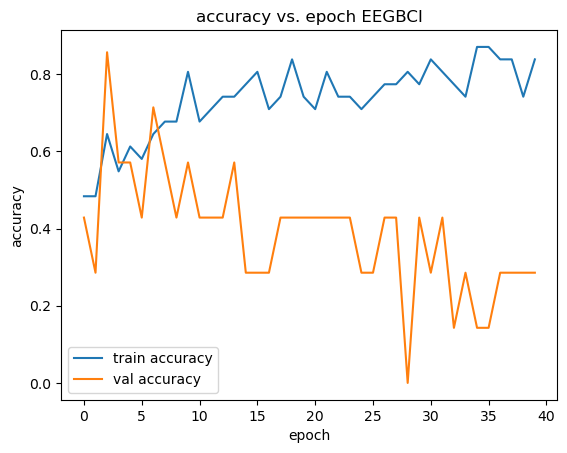

In [8]:
# create model
model = EEGNet (64, 481, verbose = True)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

batch_size = 10
num_train_epochs = 40

run_net(model, batch_size, num_train_epochs, optimizer, criterion, X_train, y_train, X_val, y_val, X_test, y_test, 'EEGBCI')
